## DESIGN 6197/4197 | AI & Design: Generative AI from MLPs to APIs
## Homework 1 | Introduction to Artificial Neural Networks | 15 Points Total

*Adapted from 4.453x Creative Machine Learning for Design @ MIT | Instructiors: Renaud Danhaive, Ous Abou Ras, Natasha Hirt, and Caitlin Mueller*

In this notebook you will get some experience building simple MLP networks to perform regression (aka fitting a curve to some data points) and classification. 

For the regression task you will need to generate some data to train your model with, then for the classification task attempt to predict the value of a hand-written digit using the **[MNIST dataset](http://yann.lecun.com/exdb/mnist/)**, which is a canonical example in ML that was often used to benchmark machine learning algorithms until recently (now, it is often seen as too simple a problem). MNIST contains 60,000 training examples and 10,000 validation examples. Each example consists of 28-x28 black-and-white image and the digit the image represents. The task at hand is thus a multi-label **classification** problem where the model needs to predict the digit given an input image.

Classification has equally important applications (cancer detection for example) as regression. In addition, it is used in generative adversarial networks, a type of neural network that is remarkably good at generating complex data, so it'll serve as an important foundation for later weeks.

MNIST is such a well-known example that the dataset is usually easily downloadable in the right format. In the case of PyTorch, we can use the `torchvision` package, which contains useful datasets, model architectures, and utility functions for computer vision.

>**Note:**
>The mamba environments for the mac and windows versions of this homework are different. The windows version is set up to install a cuda compatible version of pytorch. Pytorch is the main library we will be using for building, training, and evaluating machine >learning models. The math behind machine learning involves a lot of matrix multiplication. GPUs are highly optimized to perform these operations but the instructions are different between windows and mac. If you have an nvidia gpu in your computer then you will >benefit greatly from having the cuda version of pytorch. The default version of pytorch will run on macs with M series processors. I have tested this notebook on an M3 MacBook Pro. If you run into issues, please share them in the Teams channel for this homework.

### Imports and Setup
At the beginning of every notebook we will be importing some libraries. Pytorch is imported as `torch`, `numpy` and `matplotlib` you have seen before in HW0, tqdm is a library for creating loading bars and will be used occasionally for visualizing progress.

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Here we will just detect if you have a GPU on your computer and set it as the device for evaluation later.

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Your computations will be done on {device}")

Your computations will be done on cuda


## Part 1: Regression with an MLP

In this section you will use a MLP to fit a bunch of data points. Let's get right into it!

#### Generating your training data

The first thing we need for training any machine learning model is data! Data can come from a variety of places. If it is something that you have gone out and collected (e.g. experimental observations, real photos of the world, etc.) then it is what is often called *wild data*. However, it is not always the case that you can get wild data for your problem, in fact for many applications where you are training your own models for design applications it is likely that wild data is either very poor quality or simply does not exist. In this case it is also possible to train a model using *synthetic data*. This is data which you have generated somehow. This might be from a parametric model that you have created, from a simulation tool (think FEA or CFD), or from some other workflow that you have developed to create a diverse set of samples to train your model on. 

In our case we will be generating our own synthetic data set to train on. This data set will be points along a sine curve that have been perturbed by some random noise. You should generate points (try 20,000) that range in the x direction from  $-3\pi$ to $3\pi$ and the y values should be the sine of the x values. 

>Hint: Use the [np.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) and [np.sin](https://numpy.org/doc/stable/reference/generated/numpy.sin.html) functions.

In [3]:
#Your code here
x_start, x_end = -3*np.pi, 3*np.pi 
x = np.linspace(x_start, x_end, 20000)
y = np.sin(x)

Now plot these points to see that they make sense.

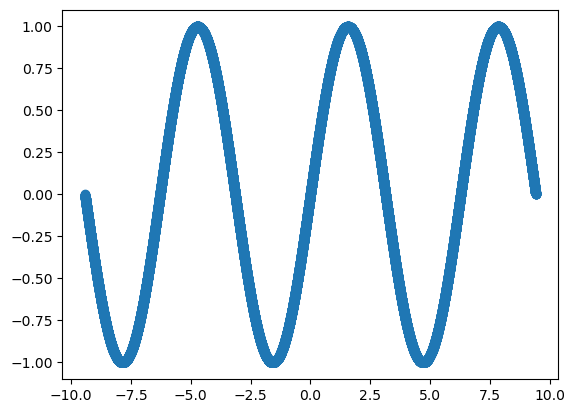

In [4]:
#No need to write code here, just run this cell.
plt.scatter(x, y)

Great! Now you have a bunch of data points to work with, however they are still very organized. We want to simulate some randomness in our data set to make it a little bit more interesting. To do this you can add a small random perturbation to each of the x and y points that you just generated. When generating synthetic data it is often a very good idea to introduce this kind of adjustment into your dataset as it will make your model more robust against small changes when you try evaluating it in the future. We will see in the future that is also useful to add random perturbations even when you have wild data in order to increase the size of your dataset. This is often referred to as *data augmentation* and you will see this term frequently when dealing with training data. 

For this specific problem you can think about this randomness like a measurement error. Perhaps you have a very fast way to take a lot of measurements, but those measurements aren't very accurate, they might be off by +/- 30% but you can make thousands of them in a second. To do this you should generate a list of small random values to add the the x and y positions of your points. Feel free to experiment with different amounts of randomness and see how your model performs as it increases. 

>Hint: use [np.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) to generate your small random values.

In [5]:
#Your code here
spread = 0.3
rand_x = np.random.normal(0, spread, x.shape) + x
rand_y = np.random.normal(0, spread, y.shape) + y

#### Data Scaling

Scaling of your data is an important step in training your model. This may not seem like a big deal, but it can dramatically impact how well your training process goes. For these points we will standardize them so that the mean of the values is 0 and the standard deviation of the values is 1. Sometimes you will normalize your values instead, this decision is somewhat model and dataset dependent.

In [6]:
#Get the mean of the x values
mean_x = np.mean(rand_x)
#Get the standard deviation of the x values
std_x = np.std(rand_x)
#Get the mean of the y values
mean_y = np.mean(rand_y)
#Get the standard deviation of the y values
std_y = np.std(rand_y)

#Standardize the x values and y values
rand_x = (rand_x - mean_x) / std_x
rand_y = (rand_y - mean_y) / std_y

norm_input = (x - mean_x) / std_x
norm_output = (y - mean_y) / std_y

#Get the min and max of the x values and y values to use later
x_min, x_max = np.min(rand_x), np.max(rand_x)
y_min, y_max = np.min(rand_y), np.max(rand_y)

Now you can plot your randomized and standardized points. This will be the dataset that you train your MLP on.

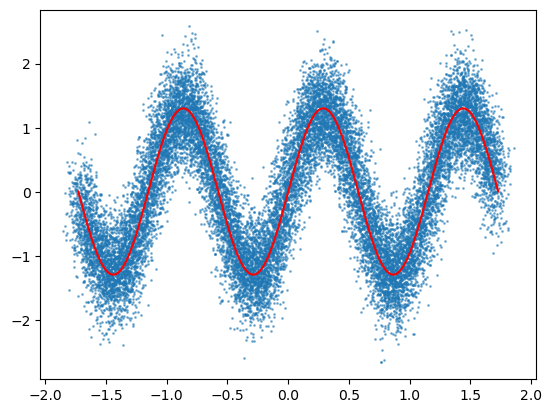

In [7]:
#No need to write code here, just run this cell.
plt.scatter(rand_x, rand_y, alpha=0.5, s=1)
plt.plot(norm_input, norm_output, color='red')


#### Now it's time to split our dataset to prepare for training

For this model we will be splitting the synthetic data from above into a training set and a test set. We will do this to leave part of the data unseen by the model during the training process so we can evaluate the performance of our model later. Pytorch has a way of storing data called a [`Datasets and Dataloaders`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) that can be used to handle training and testing data in a more modular way. Here I have defined a custom dataset that inherits from the Pytorch Dataset 

In [8]:
#No need to write code here, just run this cell.
class simpleMLP_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

Now we that we have defined a custom dataset class, we can use this to convert our synthetic data from above into a Dataset so that we can more easily split it into testing and training batches using built in pytorch utilities. We will split the data, reserving 20% for evaluating the performance of the model.

In [9]:
#No need to write code here, just run this cell.
full_dataset = simpleMLP_Dataset(rand_x, rand_y)
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])
print(len(train_dataset), len(test_dataset))

16000 4000


Next we will use the DataLoader class to create an object that will shuffle and batch the data. The batch size here is pretty arbitrary and is also one of the hyperparameters of the model, feel free to play with this value to see how it affects your model output. By setting shuffle to true, the selections for each batch will be randomized each time a new batch is selected. This helps to prevent the model from learning about chunks of data points. 

In [10]:
#No need to write code here, just run this cell.
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
print(len(train_dataloader), len(test_dataloader))

125 32


Let's take a look at one of the batches in the training dataloader. This will contain a bunch of points. Batching data is also something that will be done frequently to promote stability during training. If you run the following cell a couple of times you will see that the points change each time.

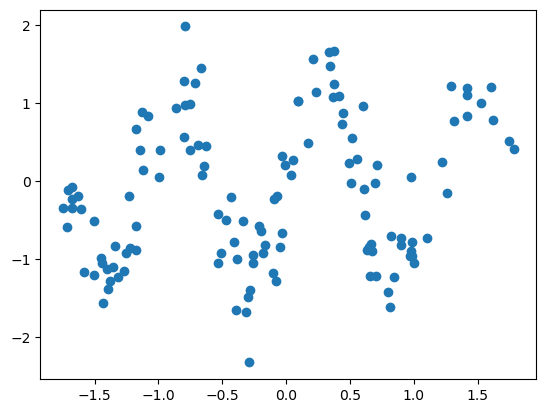

In [12]:
#No need to write code here, just run this cell.
train_input, train_output = next(iter(train_dataloader))

#You can uncomment the following lines to see the raw input and output tensors.

#print("Here is a batch of inputs (x values):\n",train_input)
#print("Here is a batch of outputs (y values): \n",train_output)

plt.scatter(train_input, train_output)

Now that you have your data prepared, it's time to work on actually setting up and training your model.

#### Set up your MLP

Pytorch makes it very simple to set up models. Once you get used to the syntax you will come to find that building the model is the easy part. The harder part is generally dataset generation and adjusting hyperparameters for your model. The goal of this model is to take in a single value (in this case it will be an x value), and return a single value (the corresponding y value for that point). Ideally we should be able to learn a function that is able to explain well the underlying function that we used to generate the dataset. Lets take a look at what is needed to define a simple model.

In [13]:
input_size = 1
hidden_size = 256
output_size = 1

model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
).to(device)

That is all you need to do to define your model. This is definitely not how you would do it in a production setting, but for this test case it really is all you need. In part 2 you will see the more common way of setting up a model.

For now, let's look a little more closely at what we did here:

We set a few variables for the width of the input, the width of the hidden layers, and the width of the output. The input and output sizes are both 1 due since we are inputting one number and expecting to get back one number, but the hidden size is somewhat arbitrary. You can also play with this value and see the effect on the model performance.

[`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) allows you to define a model where the layers inside it are assembled in the order that they are listed within the ( )

Inside of `nn.Sequential` we see the first layer of the network which is called [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear). This function takes two parameters, the first parameter is the size of the input and the second is the size of the output. The input is just our initial x value, but the output has a width of 100. This width is just an arbitrary selection on my part. Feel free to experiment with this value to see how it affects the prediction quality of your network. This is where the weights and biases live.

Next we have a [`nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) non-linearity. This function applies $ReLU(x) = max(0,x)$ element-wise to the outputs of the linear layer.

Then we have another `nn.Linear` layer with 100 input features and 100 output features, followed by another `nn.ReLU()` activation, and then finally another `nn.Linear`layer with 100 inputs and 1 output. This is the final layer of our network and hopefully will return us the correct, corresponding y value.

Let's print some information about our model.

In [14]:
#No need to write code here, just run this cell.
print(model)
params = list(model.parameters())
param_count = sum(p.numel() for p in model.parameters())
print(f"This model has {param_count} parameters.")

Sequential(
  (0): Linear(in_features=1, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
)
This model has 66561 parameters.


#### Next we will define our loss function and optimizer. 

We will be using the [`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html). This is a standard loss function and will simply measure the distance between the predicted point and the actual point and use this as the error term during the optimization. We will also be using the Adam optimizer. There are a number of different algorithms you can use, but this one is generally robust.



In [15]:
#No need to write code here, just run this cell.
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#### Training Time

Finally, it is time to train your model. Below is the loop for doing the training itself. You will see that there is a variable defined for a number of epochs, losses, best loss, and best model. The epochs are the number of times the dataloader will be called. Remember, each time the dataloader is called it returns an entire batch of values. 

tqdm just provides a loading bar UI element.

Inside this double for loop is the meat of the loop.

In [16]:
#Number of times the dataloader will be called
epochs = 50

#An empty list for tracking the model loss over time
losses = []
test_performance = []

#The best loss so far
best_loss = np.inf

#The best model so far
best_model = None

#Here is where the training of the model happens
for epoch in tqdm(range(epochs)):
    #Evaluate the model on the test dataset without calculating gradients
    epoch_test_performance = 0
    epoch_train_performance = 0


    #Check the model's performance on the test dataset before training step
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)        
        y_pred = model(x_batch)
        test_loss = loss_fn(y_pred, y_batch)
        epoch_test_performance += test_loss.item()

    #Call the dataloader and get the training data input and output in batches
    for x_batch, y_batch in train_dataloader:
        #Move the data to the device (GPU or CPU)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        #Zero out the gradients
        optimizer.zero_grad()

        #Get the model's prediction
        y_pred = model(x_batch)

        #Calculate the loss
        loss = loss_fn(y_pred, y_batch)

        #Backpropagate the loss
        loss.backward()

        #Update the model's parameters
        optimizer.step()
        
        #Append the loss to the losses list
        epoch_train_performance += loss.item()
        
        #If the loss is the best so far, save the model's state_dict
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model.state_dict()
    
    losses.append(epoch_train_performance / len(train_dataloader))
    test_performance.append(epoch_test_performance / len(test_dataloader))


    


  0%|          | 0/50 [00:00<?, ?it/s]

Now that the model is trained lets plot the loss values and test performance values over time. Ideally they should be going down over time. That means that the difference between the predictions and the actual values is becoming smaller. Over time you will develop a sense for what a good loss curve looks like.

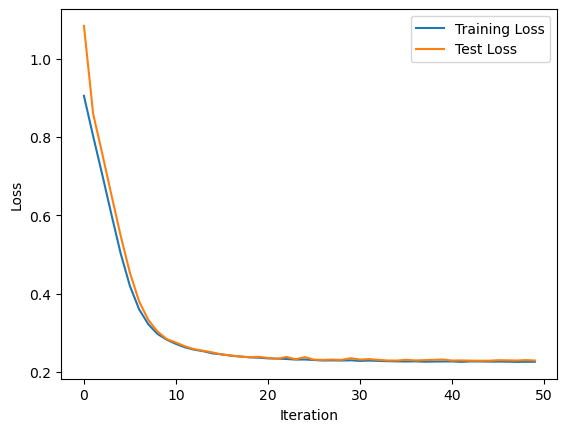

In [17]:
plt.plot(losses)
plt.plot(test_performance)
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

This looks like a decent loss curve, let's take a look at how our model is doing on some new values.

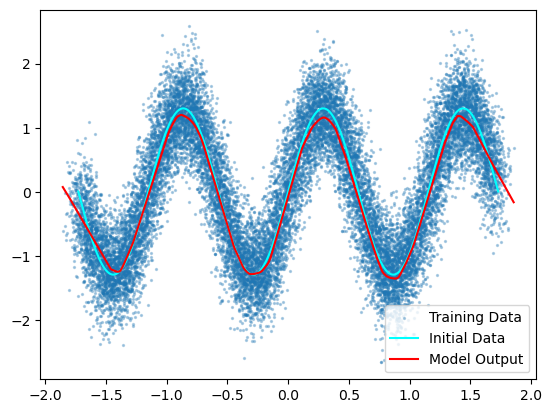

In [18]:
#Here we load the best model and evaluate it on some new points.
with torch.no_grad():
    model.load_state_dict(best_model)
    x_vals = torch.linspace(x_min, x_max, 500).unsqueeze(1).to(device)
    y_pred = model(x_vals).cpu().detach().numpy()

#Now lets plot the scaled training data and the model's prediction
plt.scatter(rand_x, rand_y, alpha=0.3, s=2)
plt.plot(norm_input, norm_output, color='cyan')
plt.plot(x_vals.cpu().detach().numpy(), y_pred, color='red')
plt.legend(["Training Data","Initial Data", "Model Output"], loc='lower right')
plt.show()

Great, if all went well then you should see a pretty decent approximation. The initial data, model output, and training data have been overlaid in this plot so you can see the deviations.

## Part 2: MNIST

In this section of the homework you will be training another small MLP to classify images of handwritten digits. You will need to fill out a bit more of the code in this section, but the concepts are very similar to the regression example above. The data will be downloaded so you need to make sure you are connected to the internet when you run this section.

#### Load data

In [20]:
mnist_training_set = torchvision.datasets.MNIST(
    "data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
mnist_validation_set = torchvision.datasets.MNIST(
    "data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:04<00:00, 1994644.96it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 888677.97it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 982414.20it/s] 


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 745238.38it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [21]:
print(mnist_training_set)
print(mnist_validation_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


We again have two datasets: one for training and one for validation. And again to actually load the data as we go we can use a nice abstraction offered by PyTorch: data loaders. With data loaders, we can specify the amount of data (i.e. the number of examples) that we will load as we iterate through the data loader and also instruct the data loader to shuffle the data every time it is iterated through. As a result, data loaders are thus very convenient for training neural networks.

In [22]:
batch_size = 64

training_dataloader = torch.utils.data.DataLoader(
    mnist_training_set, shuffle=True, batch_size=batch_size
)
validation_dataloader = torch.utils.data.DataLoader(
    mnist_validation_set, shuffle=True, batch_size=batch_size
)

Let's look at one item from the training data loader.

In [23]:
sample = next(iter(training_dataloader))
print(sample[0].shape)
print(sample[1].shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


As expected, we are getting two arrays (input and target) with a batch size of 32.

Let's plot a single example.

This digit is 5


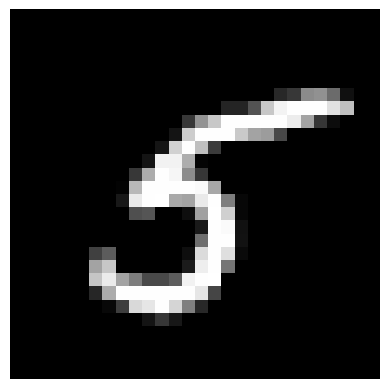

In [24]:
plt.imshow(sample[0][0, 0], cmap="gray")
plt.axis("off")
print(f"This digit is {sample[1][0]}")

And let's plot a bunch!

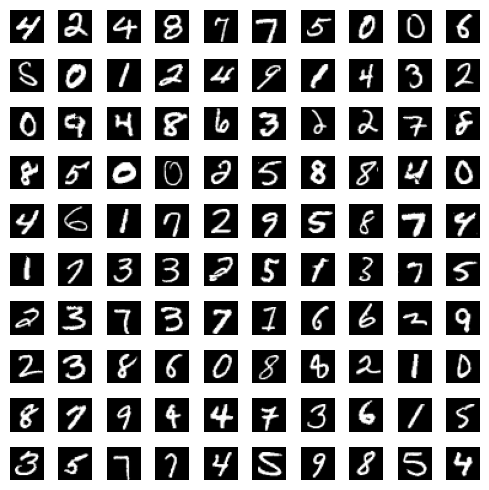

In [25]:
figs, axs = plt.subplots(10, 10, figsize=(5, 5))

for row in axs:
    for ax in row:
        sample = next(iter(training_dataloader))
        ax.imshow(sample[0][0, 0], cmap="gray")
        ax.axis("off")
plt.tight_layout()

This is a multi-label classification problem, and we will train a neural network to predict the probabilities that an input image is a given digit, i.e. the neural network will output 10 values between 0 and 1 and summing to 1.

It will not try to directly predict the digit as a continuous value because it is not a regression problem and the order of the digits in number space is not related at all to what they look like, for example 3 looks closer to 8 than it does to 4.

#### Build and train neural network
We're going to reuse our good old multi-layer perceptron architecture, which is actually not a great architecture for this task. MLPs do not take into account the structure of images, and we'll actually have to flatten the input data into a long vector as we feed to the network.

A convolutional neural network would make a lot more sense for this task, but that will be for a later week.

In any case, we only need to slighly modify our MLP implementation. As already mentioned, we need to add a flattening layer at the top. We also need to make sure we output 10 probability values. To do so, we set the last layer's output size to 10 with a log-Softmax activation function. The softmax activation function $\sigma(x_i) = \dfrac{e^{x_i}}{\sum^K_{j=1}{e^{x_j}}}$ is such that the output values are all between 0 and 1 and sum to 1 (making them valid probabilities. We then take the log of these probabilities because we'll use the negative log-likelihood loss. $Loss(F(x_i), y_i)) = -\log(p_{j=y_i})$ where $F(x_i)=[p_0, p_1, ..., p_9]$.

PyTorch has that loss function built in: we just need to provide it with the predicted log-probabilities and the actual class of the example.

The negative log-likelihood loss is really common for classification problems, and it's therefore useful to understand how/why it works. Imagine that for a given digit example with an observed value 9, the model predicts a log-probability $x$ (which could range from 0 to 1) for that class. Then, the loss function evolves as follows for different values of $x$:

/var/folders/f0/mxp05s25457dg1vkncgnbv7m0000gn/T/ipykernel_50320/360246532.py:2: RuntimeWarning: divide by zero encountered in log
  y = -np.log(x)


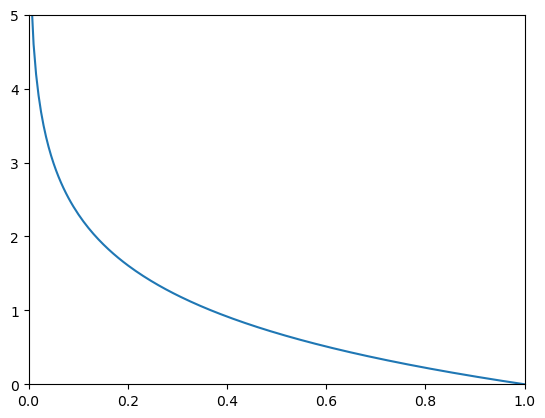

In [26]:
x = np.linspace(0, 1, 200)  # possible range of probability values
y = -np.log(x)
plt.plot(x, y)
plt.xlim(0, 1)
plt.ylim(0, 5)
plt.show()

The graph of the negative log-likelihood shows that the loss goes to zero if the model does predict a value of 1 (thus predicting the correct class) for the observed class, whereas if we predict a probability of zero (thus being as far off from the ground truth as possible), the loss shoots up to infinity.

In other words, the loss penalizes the model more as its gets further from the ground truth, which is exactly what we want of course.

#### Network architecture

Here we will use the more common way of defining a network in Pytorch. In this example we will define a class, here called mnist_mlp which inherits from nn.Module. Inside of this class are two required functions, init and forward. In init there are a few larger chunks of a network that are being defined; a layer in chunk, middle layers, and an output layer chunk. This provides a nice abstraction for building up more complex models. Then in forward this is where the data is actually passed through the network each time the model is evaluated. 

In [27]:
class mnist_mlp(nn.Module):
    def __init__(self, n_hidden_layers=6, n_hidden_neurons=32,):
        super(mnist_mlp, self).__init__()

        #Create a chunk of operations that will be used to process the input
        self.layer_in = nn.Sequential(nn.Flatten(), 
                                      nn.Linear(28 * 28, n_hidden_neurons), 
                                      nn.Tanh())
        
        #Create a list to hold the hidden layers
        hidden_layers = []
        #Add the hidden layers to the list with activation functions between them
        for _ in range(n_hidden_layers):
            hidden_layers.append(nn.Linear(n_hidden_neurons, n_hidden_neurons))
            hidden_layers.append(nn.Tanh())

        #Create a chunk of operations that will be used in the middle of the model
        self.layers_mid = nn.Sequential(*hidden_layers)

        #Create a chunk of operations that will be used to process the output
        #The output layer will have 10 neurons, one for each digit
        #The LogSoftmax function is used to convert the output to a probability distribution
        self.layer_out = nn.Sequential(nn.Linear(n_hidden_neurons, 10), 
                                       nn.LogSoftmax(dim=-1))

    def forward(self, x):
        #Pass the input through the layer_in block
        x = self.layer_in(x)

        #Pass the input through the layers_mid block
        x = self.layers_mid(x)

        #Pass the input through the layer_out block
        x = self.layer_out(x)

        return x

Create the model and pass it to your device.

In [28]:
model = mnist_mlp().to(device)

#### Training
We have our model, so let's train. As we did with the regression example we will iterate for a number of epochs, and during each of these, we'll iterate through the entire dataset once (using the data loaders).

Let's define the optimizer.

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # lr is the learning rate

And now, let's actually train the thing! We'll print out the training and validations losses and accuracies as training progresses. Initially, we would expect the average accuracy to be around 10% since the neural network basically makes random choices before it gets trained.

In [30]:
n_epochs = 10

train_loss_history = []
train_accuracy_history = []

validation_loss_history = []
validation_accuracy_history = []

n_train_examples = len(training_dataloader)  # number of training batches
n_validation_examples = len(validation_dataloader)  # number of validation batches

for i in tqdm(range(n_epochs)):
    print(f"----- Epoch {i} -----")

    # --- VALIDATION ---
    validation_loss = 0
    validation_accuracy = 0

    for sample in validation_dataloader:
        image, target_class = sample

        # model predictions
        log_probabilities = model(image.to(device))

        # compute loss
        validation_loss += (
            nn.NLLLoss()(
                log_probabilities,
                target_class.to(device),
            )
            / n_validation_examples
        )

        # compute accuracy
        class_predictions = torch.argmax(log_probabilities, axis=1)
        validation_accuracy += (
            torch.count_nonzero(class_predictions == target_class.to(device))
            / batch_size
            / n_validation_examples
        )

    validation_loss_history.append(validation_loss.item())
    validation_accuracy_history.append(validation_accuracy.item())

    # --- TRAINING ---
    loss = 0
    accuracy = 0

    for sample in tqdm(training_dataloader):
        image, target_class = sample

        # model predictions
        log_probabilities = model(image.to(device))

        batch_loss = nn.NLLLoss()(
            log_probabilities,
            target_class.to(device),
        )

        # backprop + gradient descent step
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # compute loss
        loss += batch_loss / n_train_examples

        # compute accuracy
        class_predictions = torch.argmax(log_probabilities, axis=1)
        accuracy += (
            torch.count_nonzero(class_predictions == target_class.to(device))
            / batch_size
            / n_train_examples
        )

    train_loss_history.append(loss.item())
    train_accuracy_history.append(accuracy.item())

    print(f"Training - Mean loss: {loss} | Accuracy: {int(accuracy*100)}%")
    print(
        f"Validation at epoch start - Mean loss: {validation_loss} | Accuracy: {int(validation_accuracy*100)}%"
    )

  0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 0 -----


  0%|          | 0/938 [00:00<?, ?it/s]

Training - Mean loss: 1.6772171258926392 | Accuracy: 39%
Validation at epoch start - Mean loss: 2.3145878314971924 | Accuracy: 10%
----- Epoch 1 -----


  0%|          | 0/938 [00:00<?, ?it/s]

Training - Mean loss: 0.9508247375488281 | Accuracy: 75%
Validation at epoch start - Mean loss: 1.1962871551513672 | Accuracy: 68%
----- Epoch 2 -----


  0%|          | 0/938 [00:00<?, ?it/s]

Training - Mean loss: 0.6560733914375305 | Accuracy: 82%
Validation at epoch start - Mean loss: 0.7539650201797485 | Accuracy: 80%
----- Epoch 3 -----


  0%|          | 0/938 [00:00<?, ?it/s]

Training - Mean loss: 0.5104230046272278 | Accuracy: 86%
Validation at epoch start - Mean loss: 0.5647959113121033 | Accuracy: 84%
----- Epoch 4 -----


  0%|          | 0/938 [00:00<?, ?it/s]

Training - Mean loss: 0.4231976866722107 | Accuracy: 89%
Validation at epoch start - Mean loss: 0.4651062488555908 | Accuracy: 87%
----- Epoch 5 -----


  0%|          | 0/938 [00:00<?, ?it/s]

Training - Mean loss: 0.3703153133392334 | Accuracy: 90%
Validation at epoch start - Mean loss: 0.3966034948825836 | Accuracy: 89%
----- Epoch 6 -----


  0%|          | 0/938 [00:00<?, ?it/s]

Training - Mean loss: 0.334003746509552 | Accuracy: 91%
Validation at epoch start - Mean loss: 0.3584563732147217 | Accuracy: 90%
----- Epoch 7 -----


  0%|          | 0/938 [00:00<?, ?it/s]

Training - Mean loss: 0.3065941035747528 | Accuracy: 92%
Validation at epoch start - Mean loss: 0.3350379467010498 | Accuracy: 91%
----- Epoch 8 -----


  0%|          | 0/938 [00:00<?, ?it/s]

Training - Mean loss: 0.28368934988975525 | Accuracy: 92%
Validation at epoch start - Mean loss: 0.3122915029525757 | Accuracy: 91%
----- Epoch 9 -----


  0%|          | 0/938 [00:00<?, ?it/s]

Training - Mean loss: 0.2675100266933441 | Accuracy: 93%
Validation at epoch start - Mean loss: 0.2969427704811096 | Accuracy: 91%


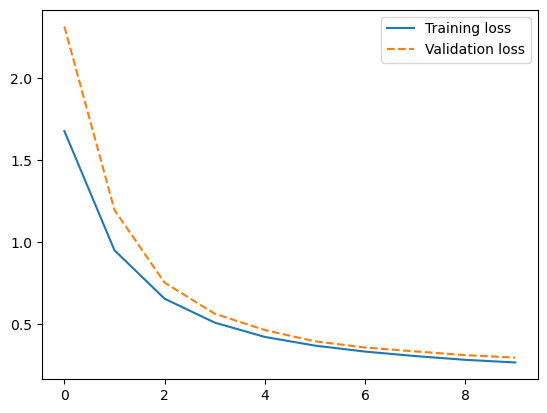

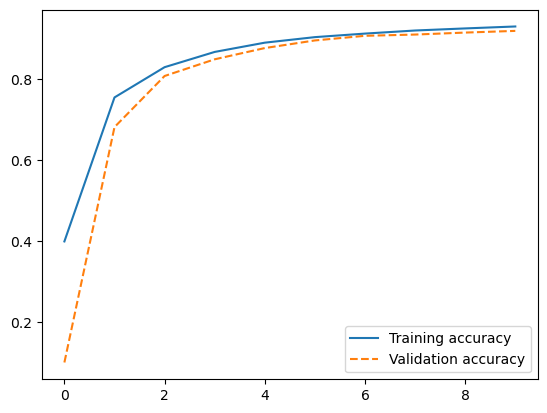

In [36]:
plt.plot(train_loss_history, label="Training loss")
plt.plot(validation_loss_history, linestyle="--", label="Validation loss")
plt.legend()
plt.show()
plt.plot(train_accuracy_history, label="Training accuracy")
plt.plot(validation_accuracy_history, linestyle="--", label="Validation accuracy")
plt.legend()
plt.show()

#### Visualize results

Now that our model is trained, let's check how it performs on examples in the validation set. Let's predict for one batch at a time, visualize the digit, and what the model prediction is.

In [37]:
images, observations = next(iter(validation_dataloader))
predicted = torch.argmax(model(images.to(device)), axis=-1)

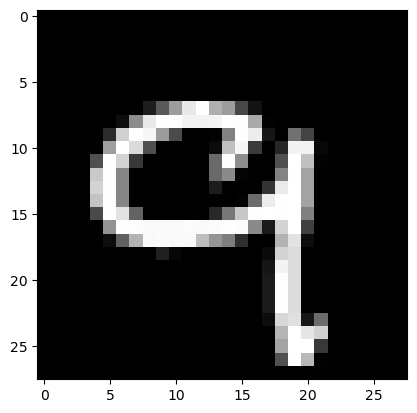

The actual digit is 9.
The predicted digit is 9.


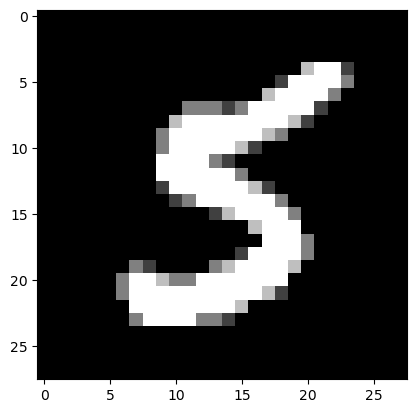

The actual digit is 5.
The predicted digit is 5.


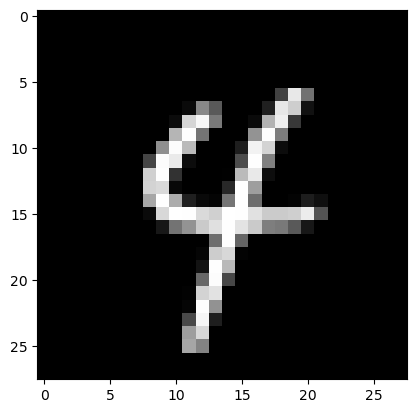

The actual digit is 4.
The predicted digit is 4.


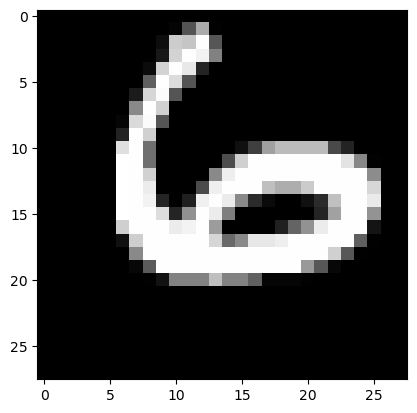

The actual digit is 6.
The predicted digit is 6.


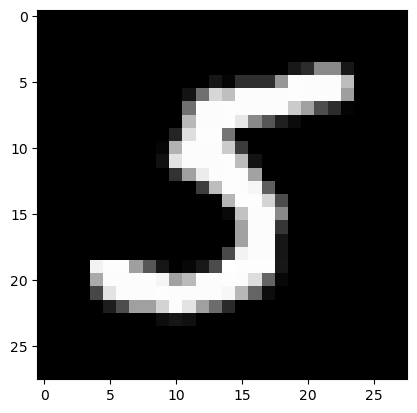

The actual digit is 5.
The predicted digit is 5.


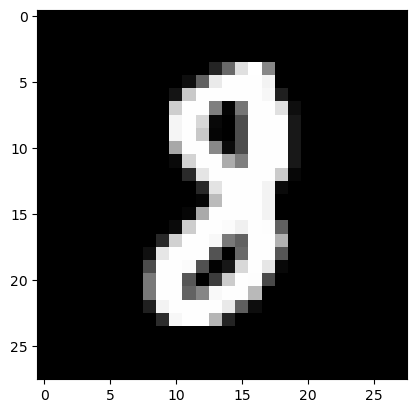

The actual digit is 8.
The predicted digit is 8.


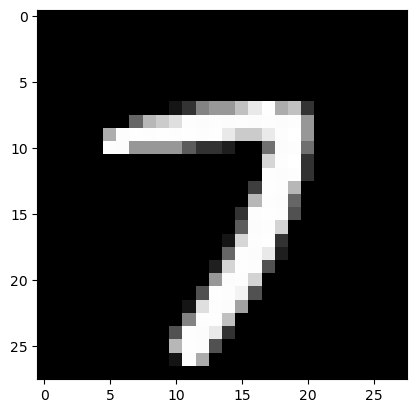

The actual digit is 7.
The predicted digit is 7.


In [38]:
for i, (img, digit, pred) in enumerate(zip(images, observations, predicted)):
    plt.imshow(img[0], cmap="gray")
    plt.grid(False)
    plt.show()
    print(f"The actual digit is {int(digit)}.")
    print(f"The predicted digit is {int(pred)}.")
    if i > 5:
        break

Let's visualize a little better the performance of our model. Of course, we can compute the accuracy, i.e. the percentage of times the model gets its predictions right, but it may be interesting to know what digit if misidentifies for another one in general. For example, we might expect the model might have more difficulty discerning ones and fours than says ones and zeros.

To shed light on this, a confusion matrix cam be really useful. Entry *ij* of the confusion matrix is the proportion of times the model produced class $j$ when the observed class was $i$. If the model is perfect, the confusion matrix is the identity matrix. Let's compute the matrix and visualize it.

In [39]:
confusion_matrix = torch.zeros((10, 10))
digit_counts = torch.zeros(10)

for sample in validation_dataloader:
    image, target_class = sample

    # model predictions
    log_probabilities = model(image.to(device))

    # compute accuracy
    class_predictions = torch.argmax(log_probabilities, axis=1)

    for i, j in zip(target_class, class_predictions):
        confusion_matrix[i, j] += 1
        digit_counts[i] += 1  # count number of occurrences of each digit

confusion_matrix = confusion_matrix / digit_counts.reshape(-1, 1) * 100

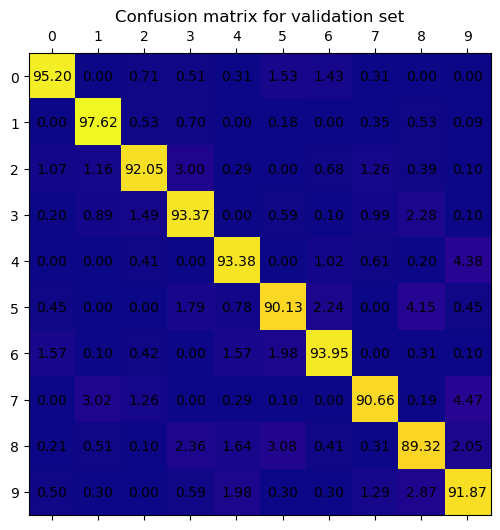

In [40]:
fig, ax = plt.subplots(figsize=(6, 6),)
plt.title("Confusion matrix for validation set")
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(confusion_matrix, cmap="plasma")

for (i, j), z in np.ndenumerate(confusion_matrix):
    ax.text(j, i, "{:0.2f}".format(z), ha="center", va="center")


ax.xaxis.set_ticks(range(10))
ax.yaxis.set_ticks(range(10))

plt.grid(False)
plt.show()

The confusion matrix shows that the model does an especially good job with 1s and not as good a job with 5s. There aren't particularly mind-blowing patterms there, but for example, it shows that when 0s are misclassified, they're most often misclassified as 6s, which makes sense.

### Conclusion
First we trained a simple MLP to fit an underlying sine wave. There are definitely other techniques you could use to do this particular task, however, the MLP is a more general tool than some of the more classical techniques you might use for this curve fitting task. With very few changes we were able to train a simple MLP to recognize digits from raw images (flattened as vectors). The reality is that this is also not the best type of neural network for this task, and a simple convolutional neural network (CNN) would easily outperform this model. In addition, this model would not deal very well with translations and rotations because it does not actually recognize shape features, it only deals with pixels on an individual basis.

To demonstrate this, we could simply consistently reorder pixels (making the digits undiscernible to a human) and train a MLP that would acheive the same performance.

We'll return to the MNIST dataset multiple times in later weeks, and we will actually train a CNN on this exact task.

Congratulations on finishing HW1. Please make sure you run all your cells and then export this notebook as an html and then save as a pdf as you did for HW0. Also make sure you commit and push your completed notebook back to github after you have finished.